### Coherence analysis

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import xarray as xr
from frites.conn.conn_sliding_windows import define_windows
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _create_kernel
from frites.stats import confidence_interval
from mne.filter import filter_data
from mne.time_frequency import (
    CrossSpectralDensity,
    psd_array_multitaper,
    psd_array_welch,
    tfr_array_morlet,
)
from scipy.stats import (
    circmean,
    circstd,
    circvar,
    kruskal,
    ks_2samp,
    mannwhitneyu,
    ttest_ind,
)
from tqdm import tqdm

from src.session import session
from src.signal.surrogates import trial_swap_surrogates
from src.util import _extract_roi, get_dates

#### Functions

In [3]:
def z_score(x, dim=-1):
    return (x - x.mean(dim)[:, None]) / x.std(dim)[:, None]

In [4]:
def WrapToPi(x):
    xwrap = np.remainder(x, 2 * np.pi)
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    return xwrap

In [5]:
def node_xr_remove_sca(xar):
    sca = ["Caudate", "Claustrum", "Thal", "Putamen"]
    _, rois = _extract_roi(xar.roi.data, " ")
    idx = np.array([r in sca for r in rois])
    return xar.isel(roi=~idx)


def flatten(xss):
    return [x for xs in xss for x in xs]


def load_session_data(sid):

    # Instantiate class
    ses = session(
        raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
        monkey="lucy",
        date=sid,
        session=1,
        slvr_msmod=False,
        only_unique_recordings=False,
        align_to="cue",
        evt_dt=[-0.65, 2.0],
    )

    # Read data from .mat files
    ses.read_from_mat()

    # Filtering by trials
    data_task = ses.filter_trials(trial_type=[1], behavioral_response=[1])
    data_fixation = ses.filter_trials(trial_type=[2], behavioral_response=None)

    attrs_task, attrs_fixation = data_task.attrs, data_fixation.attrs

    stim = np.hstack((attrs_task["stim"], attrs_fixation["stim"]))
    t_cue_on = np.hstack((attrs_task["t_cue_on"], attrs_fixation["t_cue_on"]))
    t_cue_off = np.hstack((attrs_task["t_cue_off"], attrs_fixation["t_cue_off"]))
    t_match_on = np.hstack((attrs_task["t_match_on"], attrs_fixation["t_match_on"]))

    np.nan_to_num(stim, nan=6, copy=False)

    data = xr.concat((data_task, data_fixation), "trials")
    data.attrs = attrs_task
    data.attrs["stim"] = stim
    data.attrs["t_cue_on"] = t_cue_on
    data.attrs["t_cue_off"] = t_cue_off
    data.attrs["t_match_on"] = t_match_on

    # ROIs with channels
    rois = [
        f"{roi}_{channel}" for roi, channel in zip(data.roi.data, data.channels_labels)
    ]
    data = data.assign_coords({"roi": rois})
    # data.attrs = attrs
    data.values *= 1e6

    return data

In [7]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color="b",
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [8]:
def xr_psd_array_multitaper(data, bandwidth=1, n_jobs=1, fmin=0.1, fmax=80):
    trials, roi, time = data.trials.values, data.roi.values, data.time.values

    psds_c, freqs, _ = psd_array_multitaper(
        data,
        data.fsample,
        fmin=fmin,
        fmax=fmax,
        n_jobs=n_jobs,
        bandwidth=bandwidth,
        output="complex",
    )

    # Spectra
    sxx = (psds_c * np.conj(psds_c)).mean((0, 2)).real

    sxx = xr.DataArray(sxx, dims=("roi", "freqs"), coords=(roi, freqs))

    return sxx

In [9]:
from frites.conn import conn_io
from frites.io import check_attrs, logger, set_log_level
from frites.utils import parallel_func


def _coh(w, x_s, x_t, kw_para):
    """Pairwise coherence."""
    # auto spectra (faster that w * w.conj())
    s_auto = (w.real**2 + w.imag**2).mean((0, 2))

    # define the pairwise coherence
    def pairwise_coh(w_x, w_y):
        # computes the coherence
        s_xy = (w[:, w_y, :, :] * np.conj(w[:, w_x, :, :])).mean((0, 1))
        s_xx = s_auto[w_x]
        s_yy = s_auto[w_y]
        return np.abs(s_xy) ** 2 / (s_xx * s_yy)

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_coh, **kw_para)

    # compute the single trial coherence
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def conn_spec_average(
    data,
    fmin=None,
    fmax=None,
    roi=None,
    sfreq=None,
    n_cycles=7.0,
    bandwidth=None,
    decim=1,
    kw_mt={},
    block_size=None,
    n_jobs=-1,
    verbose=None,
    dtype=np.float32,
    **kw_links,
):
    set_log_level(verbose)

    # _________________________________ INPUTS ________________________________
    # inputs conversion
    kw_links.update({"directed": False, "net": False})
    data, cfg = conn_io(
        data,
        times=None,
        roi=roi,
        agg_ch=False,
        win_sample=None,
        block_size=block_size,
        sfreq=sfreq,
        freqs=None,
        foi=None,
        sm_times=None,
        sm_freqs=None,
        verbose=verbose,
        name=f"Spectral connectivity (metric = coh)",
        kw_links=kw_links,
    )

    # extract variables
    x, trials, attrs = data.data, data["y"].data, cfg["attrs"]
    times, n_trials = data["times"].data, len(trials)
    x_s, x_t, roi_p = cfg["x_s"], cfg["x_t"], cfg["roi_p"]
    indices, sfreq = cfg["blocks"], cfg["sfreq"]
    n_pairs = len(x_s)

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    # temporal decimation
    times = times[::decim]

    # define arguments for parallel computing
    mesg = f"Estimating pairwise coh for trials %s"
    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    # show info
    logger.info(f"Computing pairwise coh (n_pairs={n_pairs}, " f"decim={decim}")

    # --------------------------- TIME-FREQUENCY --------------------------
    # time-frequency decomposition
    w, f_vec, _ = psd_array_multitaper(
        x[..., ::decim],
        sfreq,
        fmin=fmin,
        fmax=fmax,
        n_jobs=n_jobs,
        bandwidth=bandwidth,
        output="complex",
        **kw_mt,
    )
    # ______________________ CONTAINER FOR CONNECTIVITY _______________________
    dims = ("roi", "freqs")
    coords = (roi_p, f_vec)

    conn = _coh(w, x_s, x_t, kw_para)

    # configuration
    cfg = dict(
        sfreq=sfreq,
        n_cycles=n_cycles,
        mt_bandwidth=bandwidth,
        decim=decim,
    )

    # conversion
    conn = xr.DataArray(
        conn, dims=dims, name="coh", coords=coords, attrs=check_attrs({**attrs, **cfg})
    )
    return conn

In [10]:
def _phase_diff(w, x_s, x_t, kw_para):
    def pairwise_phase_diff(w_x, w_y):
        return np.unwrap(w[:, w_x, :, :] - w[:, w_y, :, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_phase_diff, **kw_para)

    # compute the single trial coherence
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def hilbert_decomposition(
    data,
    sfreq=None,
    times=None,
    roi=None,
    bands=None,
    n_jobs=1,
    verbose=None,
    dtype=np.float32,
    **kw_links,
):
    """
    Docstring
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    kw_links.update({"directed": False, "net": False})
    data, cfg = conn_io(
        data,
        times=times,
        roi=roi,
        agg_ch=False,
        win_sample=None,
        sfreq=sfreq,
        verbose=verbose,
        name=f"Hilbert Decomposition",
        kw_links=kw_links,
    )

    # Extract variables
    x, trials, attrs = data.data, data["y"].data, cfg["attrs"]
    times, n_trials = data["times"].data, len(trials)
    x_s, x_t, roi_p, roi = cfg["x_s"], cfg["x_t"], cfg["roi_p"], data["roi"].data
    indices, sfreq = cfg["blocks"], cfg["sfreq"]
    n_pairs, f_vec, n_freqs = len(x_s), np.mean(bands, axis=1), len(bands)
    # If no bands are passed use broadband signal

    _dims = ("trials", "roi", "freqs", "times")
    _coord_nodes = (trials, roi, f_vec, times)
    _coord_links = (trials, roi_p, f_vec, times)

    # Filter data in the specified bands
    x_filt = []

    for f_low, f_high in bands:

        x_filt += [
            xr.DataArray(
                filter_data(x, sfreq, f_low, f_high, n_jobs=n_jobs, verbose=verbose),
                dims=data.dims,
                coords=data.coords,
                attrs=attrs,
            )
        ]

    x_filt = xr.concat(x_filt, "freqs").transpose("trials", "roi", "freqs", "times")

    # Hilbert coefficients
    h = scipy.signal.hilbert(x_filt, axis=3)

    # Power and phase time-series
    power = (h * np.conj(h)).real
    phase = np.angle(h)

    # Compute phase-differences in parellel
    # show info
    logger.info(
        f"Computing pairwise phase difference (n_pairs={n_pairs}, " f"n_bands={n_freqs}"
    )
    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)
    delta_phase = np.stack(_phase_diff(phase, x_s, x_t, kw_para), axis=1)

    # Wrapp to xrray
    power = xr.DataArray(
        power, dims=_dims, coords=_coord_nodes, attrs=attrs, name="power"
    )
    phase = xr.DataArray(
        phase, dims=_dims, coords=_coord_nodes, attrs=attrs, name="phase"
    )
    delta_phase = xr.DataArray(
        delta_phase, dims=_dims, coords=_coord_links, attrs=attrs, name="phase_diff"
    )

    return power, phase, delta_phase

#### Setting configurations

In [11]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [12]:
metric = "coh"
monkey = "lucy"

In [13]:
sessions = get_dates(monkey)

In [14]:
rois_sel = np.array([103, 17])

#### Load data

In [15]:
data = load_session_data("141017")

In [16]:
data.t_cue_on.shape

(398,)

##### Create surrogate data

In [17]:
rois_sel = np.array([103, 17])
rois = data.roi.values
rois_idx = np.nonzero(np.in1d(data.channels_labels, rois_sel))[0]
data = data.isel(roi=rois_idx)

In [18]:
data = data.isel(roi=rois_idx)

In [19]:
data_surr = [
    trial_swap_surrogates(data, seed=s + 100, verbose=False) for s in tqdm(range(10))
]

data_surr = xr.concat(data_surr, "surr")

100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 54.08it/s]


##### Create filtered data (5-15 Hz)

In [20]:
data_filt = xr.DataArray(
    filter_data(data.data, 1000, 5, 15, n_jobs=20, verbose=False),
    dims=data.dims,
    coords=data.coords,
)

In [21]:
data_surr_filt = []
for _d in tqdm(data_surr):
    data_surr_filt += [
        xr.DataArray(
            filter_data(_d.data, 1000, 5, 15, n_jobs=20, verbose=False),
            dims=_d.dims,
            coords=_d.coords,
        )
    ]

100%|████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.67it/s]


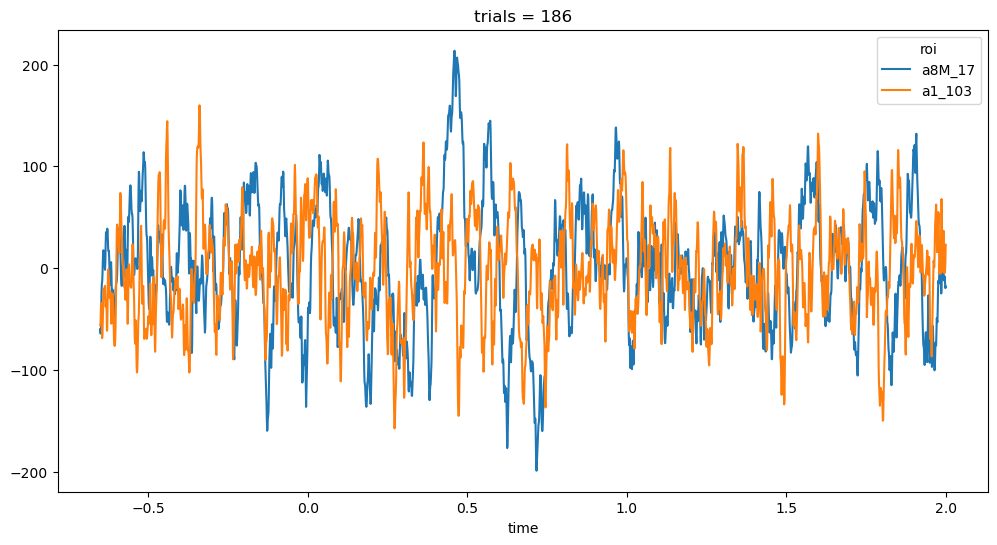

In [22]:
plt.figure(figsize=(12, 6))
data.isel(trials=100).plot(hue="roi");

In [23]:
sxx = xr_psd_array_multitaper(data)
coh = conn_spec_average(
    data,
    fmin=0.1,
    fmax=80,
    sfreq=data.fsample,
    roi=data.roi.values,
    bandwidth=4,
    decim=1,
    n_jobs=10,
)

    Using multitaper spectrum estimation with 2 DPSS windows


WARNING | No time vector. A default one is created
Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise coh (n_pairs=1, decim=1


    Using multitaper spectrum estimation with 9 DPSS windows


  0%|          |  : 0/1 [00:00<?,       ?it/s]

In [24]:
coh_surr = []

for _d in tqdm(data_surr):

    coh_surr += [
        conn_spec_average(
            _d,
            fmin=0.1,
            fmax=80,
            sfreq=data.fsample,
            roi=data.roi.values,
            bandwidth=4,
            decim=1,
            n_jobs=10,
            verbose=False,
        )
    ]

100%|████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


In [27]:
coh_low_thr = xr.concat(coh_surr, "surr").quantile(0.05, "surr")
coh_high_thr = xr.concat(coh_surr, "surr").quantile(0.99, "surr")

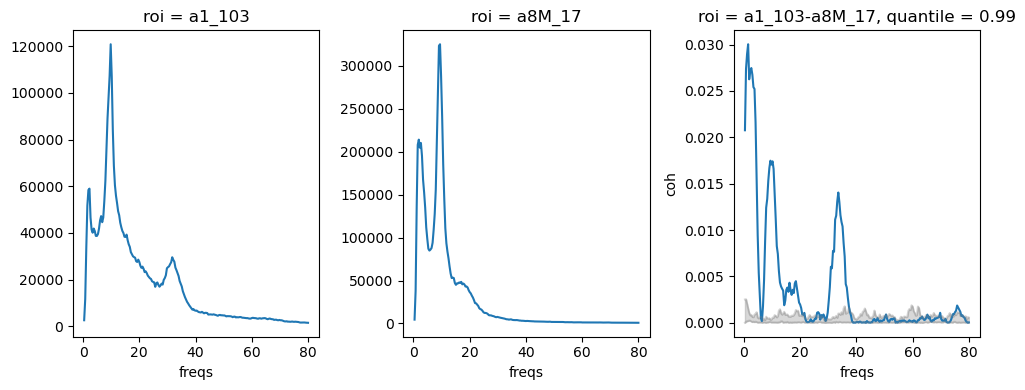

In [28]:
plt.figure(figsize=(10, 4))

x_s, x_t = _extract_roi(coh.roi.values, "-")
pos = 1
for s, t in zip(x_s, x_t):

    plt.subplot(coh.sizes["roi"], 3, pos)
    sxx.sel(roi=s).plot()
    if pos == 0:
        plt.titel("POWER SOURCE")
    pos = pos + 1
    plt.subplot(coh.sizes["roi"], 3, pos)
    sxx.sel(roi=t).plot()
    if pos == 1:
        plt.titel("POWER TARGET")
    pos = pos + 1
    plt.subplot(coh.sizes["roi"], 3, pos)
    coh.sel(roi=f"{s}-{t}").plot()
    plt.fill_between(
        coh_low_thr.freqs,
        coh_low_thr.sel(roi=f"{s}-{t}"),
        coh_high_thr.sel(roi=f"{s}-{t}"),
        alpha=0.3,
        color="gray",
    )
    coh_low_thr.sel(roi=f"{s}-{t}").plot(c="gray", alpha=0.3)
    coh_high_thr.sel(roi=f"{s}-{t}").plot(c="gray", alpha=0.3)
    if pos == 2:
        plt.titel("COHERENCE")
    pos = pos + 1

plt.tight_layout()

#### Single trial power, phase and phase difference

In [36]:
freqs = np.linspace(0.1, 80, 50)

W = tfr_array_morlet(
    data.values, 1000, freqs, freqs / 4, output="complex", n_jobs=1, zero_mean=False
)

S = xr.DataArray(
    (W * np.conj(W)).real,
    dims=("trials", "roi", "freqs", "times"),
    coords=(
        data.trials,
        data.roi,
        freqs,
        data.time,
    ),
).sel(freqs=slice(5, 15)).mean("freqs")

In [37]:
x = data_filt.sel(roi="a8M_17").isel(trials=0)
y = S.isel(trials=0).sel(roi="a8M_17")

x = (x - x.mean("time")) / x.std("time")
y = (y - y.mean("times")) / y.std("times")

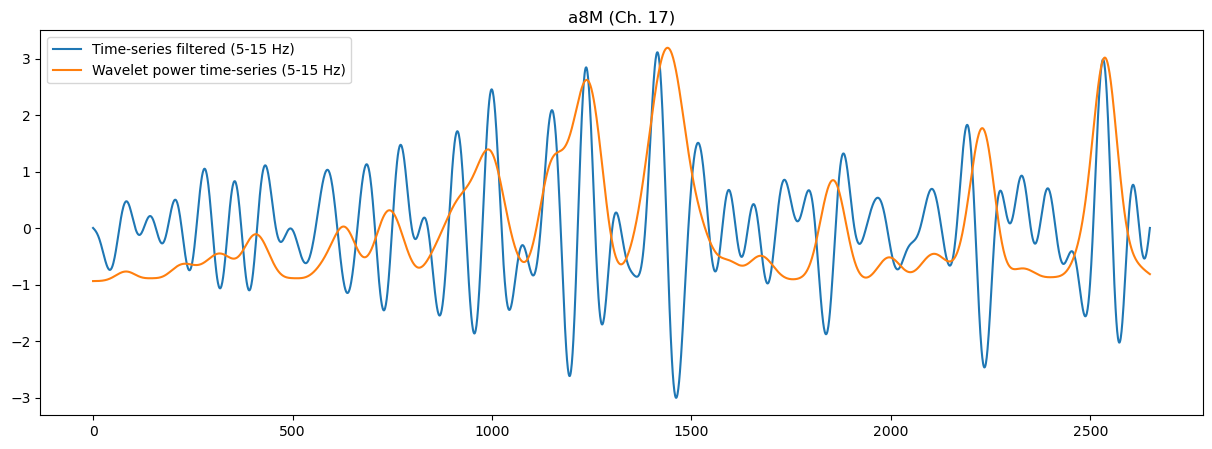

In [38]:
plt.figure(figsize=(15, 5))
plt.plot(x, label="Time-series filtered (5-15 Hz)")
plt.plot(y, label="Wavelet power time-series (5-15 Hz)")
plt.title("a8M (Ch. 17)")
plt.legend()

In [39]:
S_surr, phi_surr, pd_surr = hilbert_decomposition(
    data_surr[5],
    sfreq=1000,
    times="time",
    roi="roi",
    bands=[[0, 10], [5, 15]],
    n_jobs=20,
    verbose=False,
    dtype=np.float32,
)

In [40]:
cc, cc_surr = [], []
inst_cc, inst_cc_surr = [], []

for s, t in zip(x_s, x_t):

    x = z_score(S.sel(roi=s).data.squeeze())
    y = z_score(S.sel(roi=t).data.squeeze())

    x_surr = z_score(
        S_surr.sel(roi=s).data.squeeze(),
    )
    y_surr = z_score(
        S_surr.sel(roi=t).data.squeeze(),
    )

    cc += [(x * y).mean(-1)]
    cc_surr += [(x_surr * y_surr).mean(-1)]

    x_nn = S.sel(roi=s).data.squeeze()
    y_nn = S.sel(roi=t).data.squeeze()
    x_nn_surr = S_surr.sel(roi=s).data.squeeze()
    y_nn_surr = S_surr.sel(roi=t).data.squeeze()

    inst_cc += [(x_nn * y_nn)]

    inst_cc_surr += [(x_nn_surr * y_nn_surr)]

cc = xr.DataArray(
    np.stack(cc, axis=1),
    dims=("trials", "roi"),
    coords=(S.trials.values, coh.roi.values),
)

cc_surr = xr.DataArray(
    np.stack(cc_surr, axis=1),
    dims=("trials", "roi"),
    coords=(S.trials.values, coh.roi.values),
)

inst_cc = xr.DataArray(
    np.stack(inst_cc, axis=1),
    dims=("trials", "roi", "times"),
    coords=(S.trials.values, coh.roi.values, data.time.values),
)

inst_cc_surr = xr.DataArray(
    np.stack(inst_cc_surr, axis=1),
    dims=("trials", "roi", "times"),
    coords=(S.trials.values, coh.roi.values, data.time.values),
)

ValueError: operands could not be broadcast together with shapes (398,2,2650) (398,1,2) 

In [ ]:
plt.figure(figsize=(8, 8))
pvalues = []
mus = []
for pos in tqdm(range(coh.sizes["roi"])):

    p = ks_2samp(cc_surr[:, pos].data, cc[:, pos].data).pvalue

    sns.histplot(data=cc_surr[:, pos].data, color="gray", alpha=0.2)
    sns.histplot(
        data=cc[:, pos].data,
        label=f"mu={cc[:, pos].data.mean():.3f}; p={np.round(p, 3) + 1e-3}",
    )
    plt.title(f"{cc.roi.values[pos]}")

    pvalues += [p]
    mus += [cc[:, pos].data.mean()]

    plt.legend()
plt.tight_layout()

0.0 0.25


100%|█████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


0.25 0.5


100%|█████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


0.5 0.75


100%|█████████████████████████| 1/1 [00:00<00:00, 11.96it/s]


0.75 1


100%|█████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


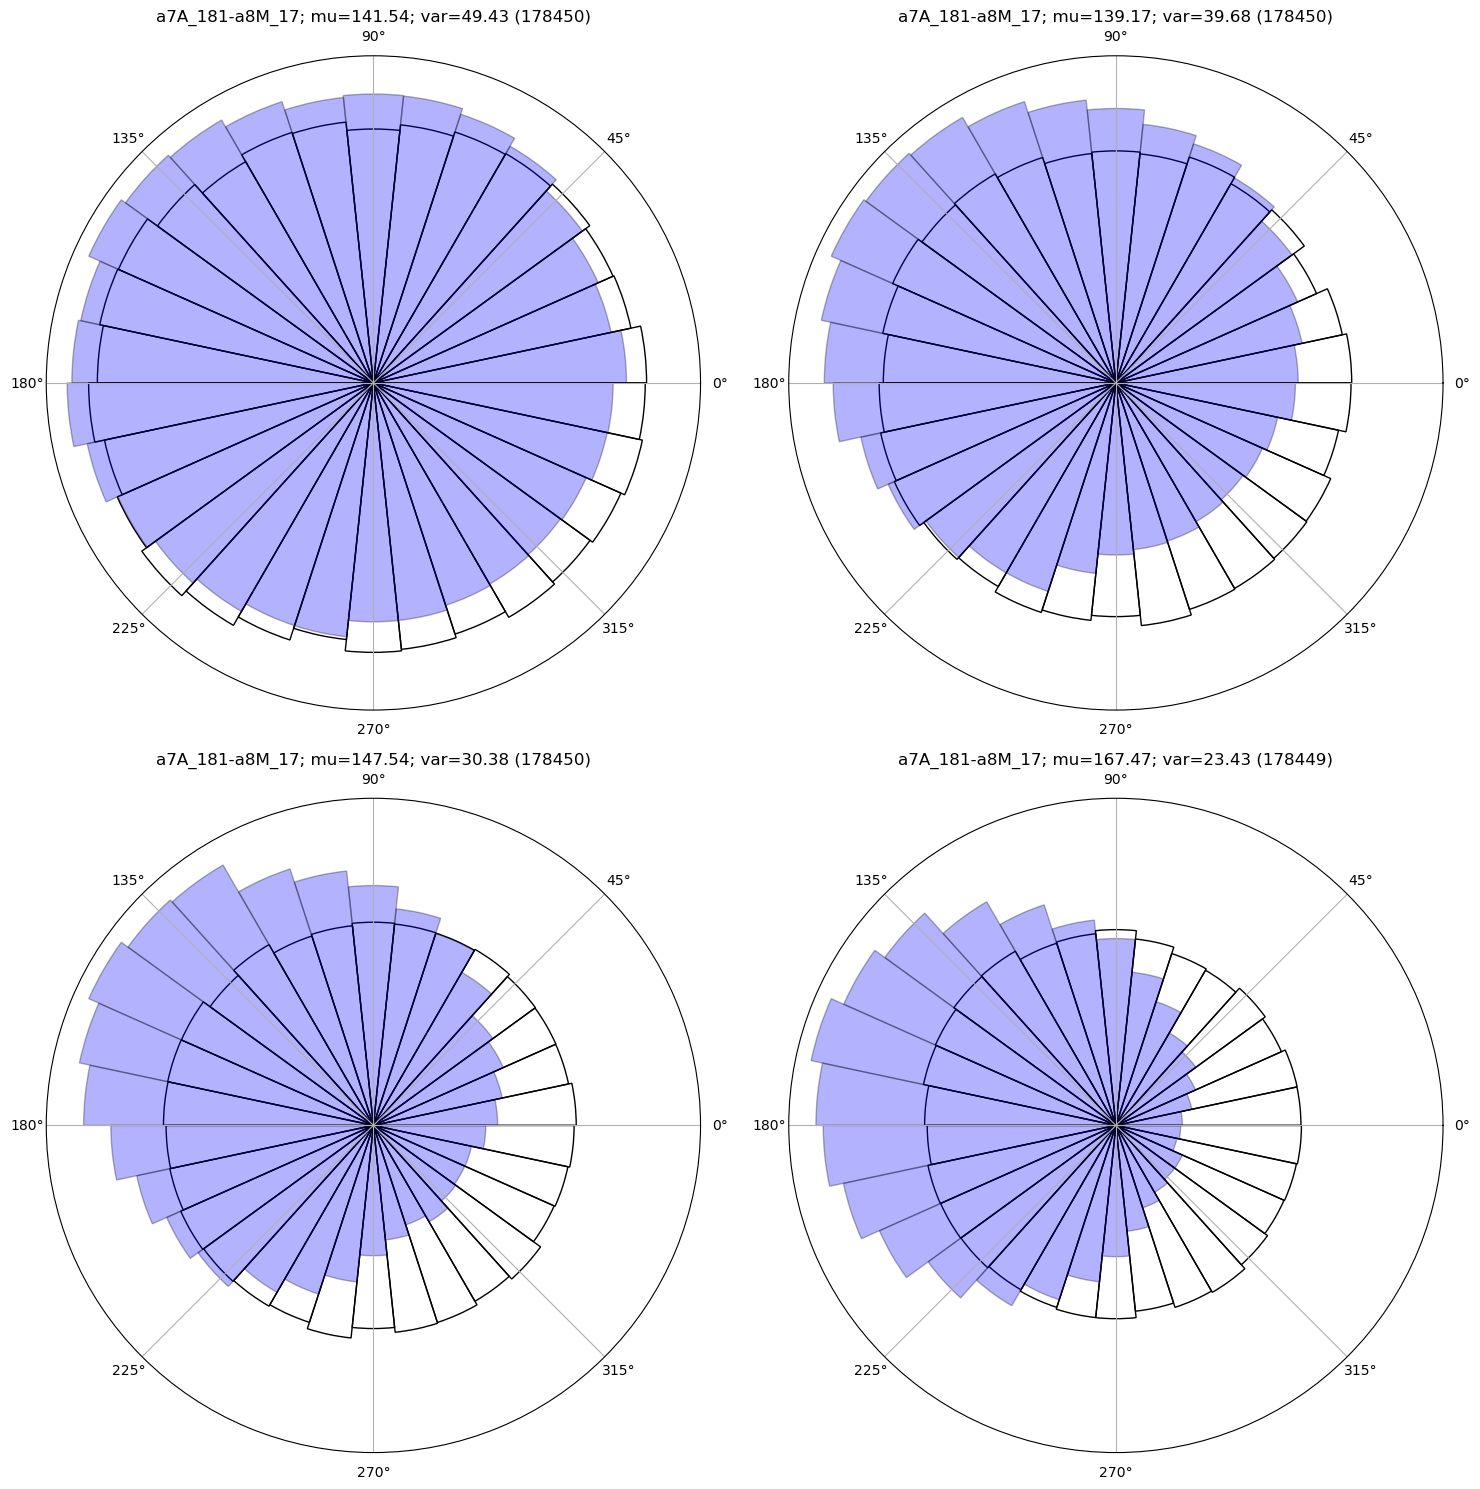

In [37]:
plt.figure(figsize=(15, 15))

quantiles_l = [0.0, 0.25, 0.50, 0.75]
quantiles_u = [0.25, 0.50, 0.75, 1]

for i, (q_l, q_u) in enumerate(zip(quantiles_l, quantiles_u)):
    print(q_l, q_u)
    ax = plt.subplot(2, 2, i + 1, projection="polar")
    var = []
    for pos in tqdm(range(coh.sizes["roi"])):

        ql = np.quantile(inst_cc[:, pos].data.flatten(), q_l)
        qu = np.quantile(inst_cc[:, pos].data.flatten(), q_u)

        idx = np.logical_and(
            (inst_cc[:, pos].data).flatten() >= ql,
            (inst_cc[:, pos].data).flatten() < qu,
        )

        n_surr, bins_surr, patches_surr = circular_hist(
            ax,
            pd_surr[:, pos].data.flatten()[idx],
            bins=30,
            fill=False,
            alpha=1,
        )
        n, bins, patches = circular_hist(
            ax,
            pd[:, pos].data.flatten()[idx],
            bins=30,
            fill=True,
        )
        n_samples = (idx).sum()
        mean = circmean(pd[:, pos].data.flatten()[idx]) * 180 / np.pi
        _var = circvar(pd[:, pos].data.flatten()[idx]) * 180 / np.pi
        var += [circvar(pd[:, pos].data.flatten()[idx]) * 180 / np.pi]
        plt.title(f"{coh.roi.values[pos]}; mu={mean:.2f}; var={_var:.2f} ({n_samples})")
plt.tight_layout()

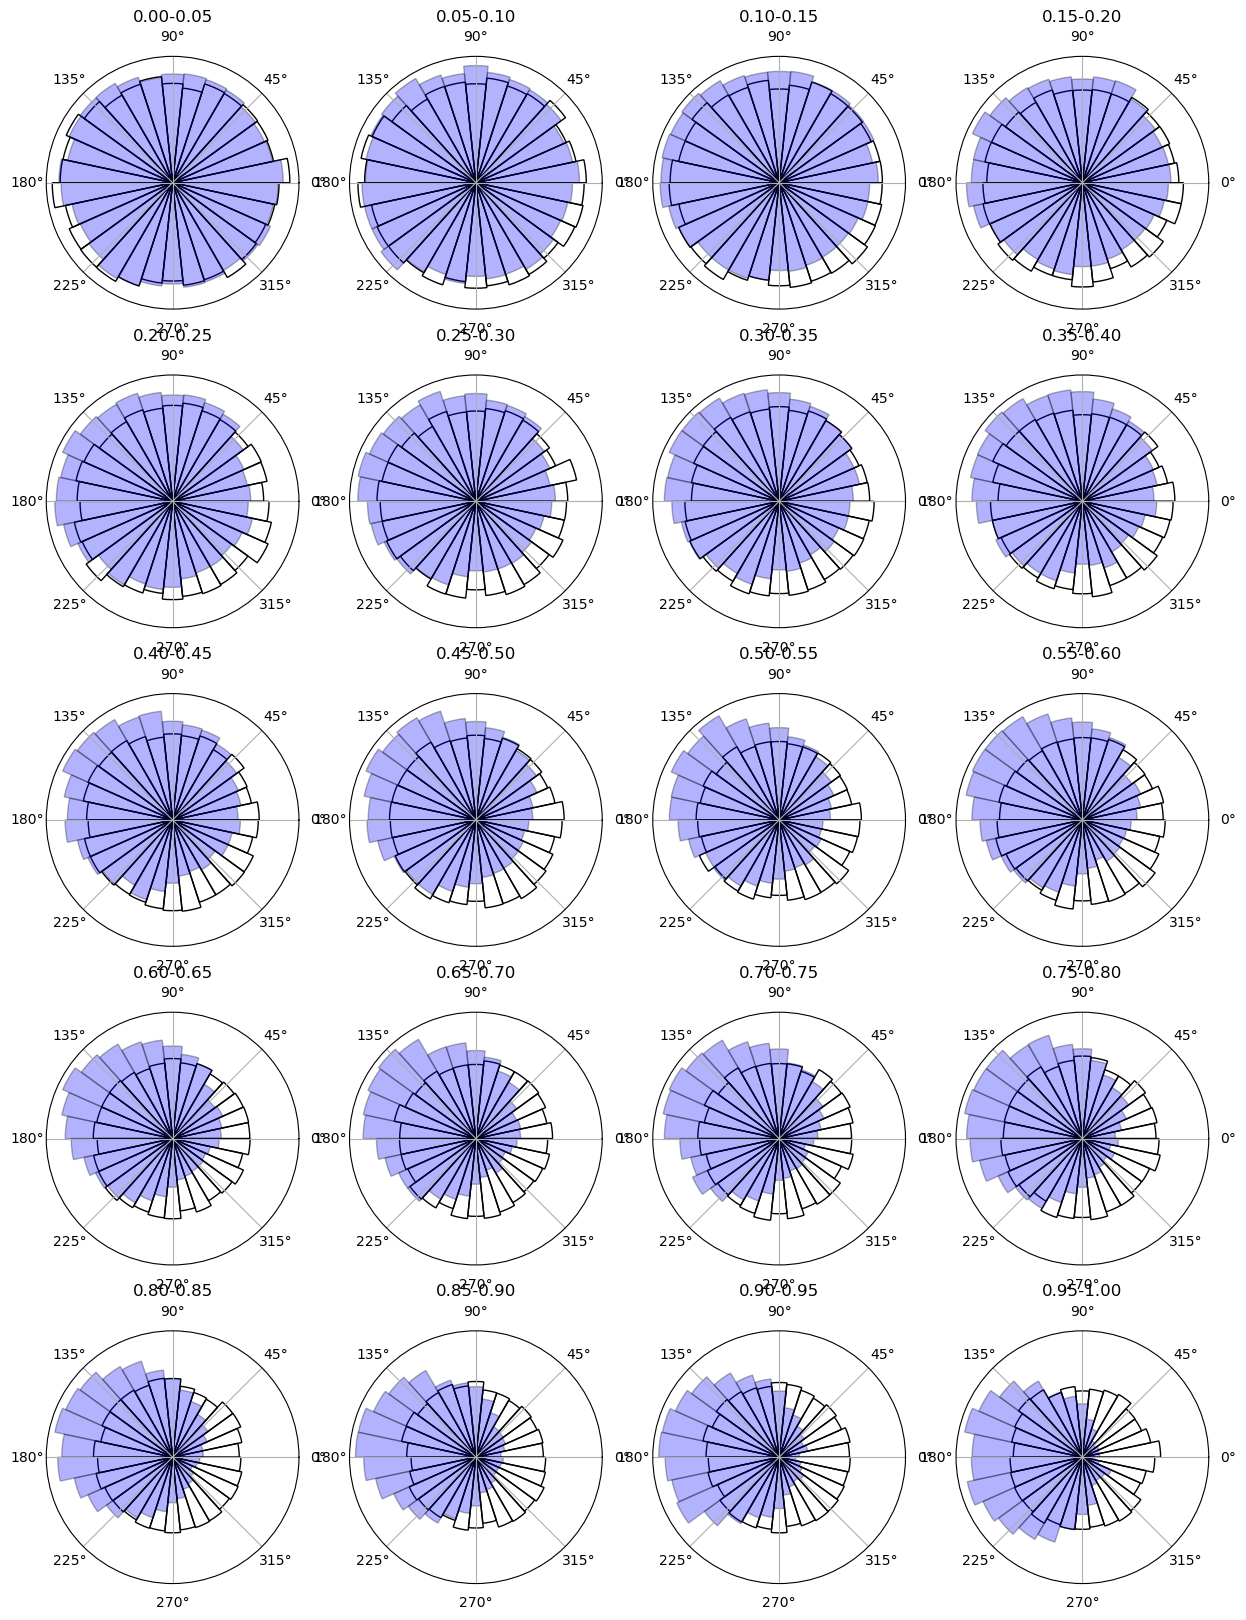

In [38]:
plt.figure(figsize=(15, 20))

quantiles_l = np.arange(0, 1, 0.05)
quantiles_u = np.arange(0, 1, 0.05) + 0.05

for i, (q_l, q_u) in enumerate(zip(quantiles_l, quantiles_u)):

    ax = plt.subplot(5, 4, i + 1, projection="polar")
    var = []
    pos = 0

    ql = np.quantile(inst_cc[:, pos].data.flatten(), q_l)
    qu = np.quantile(inst_cc[:, pos].data.flatten(), q_u)

    idx = np.logical_and(
        (inst_cc[:, pos].data).flatten() >= ql,
        (inst_cc[:, pos].data).flatten() < qu,
    )

    n_surr, bins_surr, patches_surr = circular_hist(
        ax,
        pd_surr[:, pos].data.flatten()[idx],
        bins=30,
        fill=False,
        alpha=1,
    )
    n, bins, patches = circular_hist(
        ax,
        pd[:, pos].data.flatten()[idx],
        bins=30,
        fill=True,
    )
    n_samples = (idx).sum()
    mean = circmean(pd[:, pos].data.flatten()[idx]) * 180 / np.pi
    _var = circstd(pd[:, pos].data.flatten()[idx]) * 180 / np.pi
    var += [circstd(pd[:, pos].data.flatten()[idx]) * 180 / np.pi]
    plt.title(f"{q_l:.2f}-{q_u:.2f}")

In [39]:
plt.figure(figsize=(15, 15))

quantiles_l = np.arange(0, 1, 0.05)
quantiles_u = np.arange(0, 1, 0.05) + 0.05
var = []
mu = []
var_surr = []

for i, (q_l, q_u) in enumerate(zip(quantiles_l, quantiles_u)):
    print(q_l, q_u)
    pos = 0

    ql = np.quantile(inst_cc[:, pos].data.flatten(), q_l)
    qu = np.quantile(inst_cc[:, pos].data.flatten(), q_u)

    idx = np.logical_and(
        (inst_cc[:, pos].data).flatten() >= ql,
        (inst_cc[:, pos].data).flatten() < qu,
    )

    n_surr, bins_surr, patches_surr = circular_hist(
        ax,
        pd_surr[:, pos].data.flatten()[idx],
        bins=30,
        fill=False,
        alpha=1,
    )
    n, bins, patches = circular_hist(
        ax,
        pd[:, pos].data.flatten()[idx],
        bins=30,
        fill=True,
    )
    n_samples = (idx).sum()
    mean = (
        circmean(WrapToPi(pd[:, pos].data.flatten()[idx]), low=-np.pi, high=np.pi)
        * 180
        / np.pi
    )
    mu += [mean]
    _var = circvar(WrapToPi(pd[:, pos].data.flatten()[idx])) * 180 / np.pi
    var += [
        circstd(WrapToPi(pd[:, pos].data.flatten()[idx]), low=-np.pi, high=np.pi)
        * 180
        / np.pi
    ]
    var_surr += [circstd(pd_surr[:, pos].data.flatten()[idx]) * 180 / np.pi]
plt.show()

0.0 0.05
0.05 0.1
0.1 0.15000000000000002
0.15000000000000002 0.2
0.2 0.25
0.25 0.3
0.30000000000000004 0.35000000000000003
0.35000000000000003 0.4
0.4 0.45
0.45 0.5
0.5 0.55
0.55 0.6000000000000001
0.6000000000000001 0.6500000000000001
0.65 0.7000000000000001
0.7000000000000001 0.7500000000000001
0.75 0.8
0.8 0.8500000000000001
0.8500000000000001 0.9000000000000001
0.9 0.9500000000000001
0.9500000000000001 1.0


<Figure size 1500x1500 with 0 Axes>

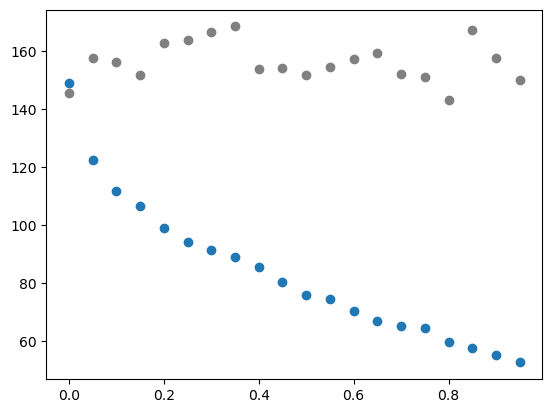

In [40]:
plt.scatter(quantiles_l, var_surr, c="gray")
plt.scatter(quantiles_l, var)